# Plot citation statistics for CMIP overview publications

In [1]:
# Updates
# PJD  5 Apr 2023 - Started
# PJD 13 Apr 2023 - Updated citation counts
# PJD 14 Apr 2023 - Augmented to include comparison models (CCSM4, CESM1, CESM2, E3SM-1-0)
# PJD 14 Apr 2023 - Augmented to consider all CMIP6 MIP papers
# PJD 12 Jul 2023 - Add CDRMIP durack1/MIPPlots#1; update all entries
# PJD 12 Jul 2023 - Add Charney 1979 and FANGIO/Cess 1990 durack1/MIPPlots#2
# PJD 26 Jul 2023 - Use per-MIP totals (from 12 Jul) to evaluate CMIP6 contributions
# PJD 14 Aug 2023 - Updated citation counts from WoS
# PJD 15 Aug 2023 - Updated bar plot
# PJD 18 Oct 2023 - Updated to write out CMIP3, CMIP5, CMIP6, CMIP6 Composite totals
# PJD 20 Dec 2023 - Updated citation counts from WoS and GSchol; Add CMIP6Plus
# PJD 20 Dec 2023 - Commenting 2024 values to prevent flat line
# PJD  2 May 2024 - Updating to use WoS Expanded API
#                 TODO: UserWarning: FixedFormatter can be solved with guidance from
#                 https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator

# WoS APIs: WoS Expanded API required to get citations per year
# https://developer.clarivate.com/apis/wos-starter, https://developer.clarivate.com/apis
# ~/sync/Docs/admin/LLNL/24/230705_Clarivate-WebOfScience-API

## imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import datetime
import logging
import os
import requests

## function defs

In [106]:
WOS_API_URL = "https://wos-api.clarivate.com/api/wos"  # API Expanded
# https://api.clarivate.com/swagger-ui/?apikey=none&url=https%3A%2F%2Fdeveloper.clarivate.com%2Fapis%2Fwos%2Fswagger
WoSStarter_API_URL = "https://api.clarivate.com/apis/wos-starter/v1"  # Starter API
# https://api.clarivate.com/swagger-ui/?apikey=none&url=https%3A%2F%2Fdeveloper.clarivate.com%2Fapis%2Fwos-starter%2Fswagger

def grabCitationReport(queryId, apiKey, params={}):
    """
    Use queryId to grab json output - every query counts as 1 against quota
    """
    headers = {"Accept": "application/json", "X-ApiKey": apiKey}
    r = requests.get(
        WOS_API_URL + "/citation-report/" + str(queryId), params=params, headers=headers
    )
    try:
        rj = r.json()
        logging.debug("API response: {}".format(rj))
        return rj
    except:
        logging.exception("Citation report for queryId {} failed".format(queryId))
        raise


def grabQueryId(query, apiKey, params={}):
    """
    Send API dummy call - ping to get query ID, start connection
    """
    data = []
    # logger.debug('Query ID: {}'.format(queryId))

    query = {"databaseId": "WOS", "usrQuery": query, "count": 0, "firstRecord": 1}
    query.update(params)
    headers = {"Accept": "application/json", "X-ApiKey": apiKey}
    # logging.info('Query parameters: {}'.format(query))
    # print(query)
    r = requests.get(WOS_API_URL, params=query, headers=headers)
    try:
        # print(r.text)
        rj = r.json()
        # print(rj)
        logging.debug("API response: {}".format(rj))
        queryId = rj["QueryResult"]["QueryID"]
        return queryId
    except:
        logging.exception(query)
        raise


def grabQueryReport(queryId, apiKey, params={}):
    """
    Use queryId to grab json output - every query counts as 1 against quota
    """
    headers = {"Accept": "application/json", "X-ApiKey": apiKey}
    r = requests.get(
        WOS_API_URL + "/query/" + str(queryId), params=params, headers=headers
    )
    try:
        rj = r.json()
        logging.debug("API response: {}".format(rj))
        return rj
    except:
        logging.exception("Citation report for queryId {} failed".format(queryId))
        raise


def pullStats(doi, apiKey):
    """
    From WoS Expanded API DOI object extract time history of citations
    along with total citation count
    """
    data = []
    # construct per call arguments and send to API
    params = "DO={}".format(doi)
    queryId = grabQueryId(params, apiKey)
    # query
    query = grabQueryReport(queryId, apiKey)
    pubYr = query["Records"]["records"]["REC"][0]["static_data"]["summary"]["pub_info"]["pubyear"]
    # citation-report
    crParams = {"reportLevel": "WOS"}
    crData = grabCitationReport(queryId, apiKey, crParams)
    # pull entries out of data object
    citingYrsDict = crData[0]["CitingYears"]
    citingYrs = list(citingYrsDict.values())
    timesCited = crData[0]["TimesCited"]

    # create filled pad list based on fangio 1990 published, 1991 citation to present
    currentYr = datetime.date.today().year
    tmp = np.arange(1990, currentYr+1)
    citingYrsPad = [np.nan]*len(tmp)    

    # ascertain length; generate padded citingYears - check pubYr against citeStartYr
    citeStartYr = int(list(citingYearsDict.keys())[0])
    startInd = citeStartYr-pubYr  # 0 if cited same year published
    print("startInd:", startInd)

    if startInd == 1:
        citingYrsPad[0] = 0
    else:
        citingYrsPad[0:startInd] = int(np.zeros(startInd))
    citingYrsPad[startInd:len(citingYears)] = citingYears

    return timesCited, citingYrs, citingYrsPad, citingYrsDict


## define time info

In [4]:
timeNow = datetime.datetime.now()
timeFormat = timeNow.strftime("%y%m%dT%H%M%S")
print("timeFormat:", timeFormat)

timeFormat: 240502T120148


## define input data from WoS API call

In [116]:
APIKEY = "BBBB"  # "WOS_EXPANDED_API_KEY"
doi = "10.1175/1520-0477-76.6.951"  #"10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2"  #"10.1029/JD095iD10p16601"

params = "DO={}".format(doi)
queryId = grabQueryId(params, apiKey)
# query
query = grabQueryReport(queryId, apiKey)
#pubYr = query["Records"]["records"]["REC"][0]["static_data"]["summary"]["pub_info"]["pubyear"]
query

# timesCited, citingYrs, citingYrsPad, citingYrsDict = pullStats(doi, APIKEY)
# list(zip(citingYearsDict.values(), fangio))  # compare two lists

{'code': 'Bad Request',
 'message': 'Server.invalidInput, First record 1 is more than the available amount 0 (customer: LAWRENCE LIVERMORE NATIONAL LABORATORY)',
 'id': '2ee1b73f-296a-4dde-aba4-3e6e1dc7dbef'}

In [113]:
print(timesCited)
print(len(citingYrs), citingYrs)
print(len(citingYrsPad), citingYrsPad)
amip1 = [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16,
         21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20]
print(len(amip1), amip1)
print("citeYrs", list(citingYrsDict.keys())[0], list(citingYrsDict.keys())[-1])

961
32 ['1', '18', '50', '54', '60', '67', '60', '62', '39', '38', '48', '23', '22', '23', '21', '20', '14', '17', '21', '18', '21', '25', '30', '33', '24', '27', '27', '25', '23', '21', '22', '7']
36 [0, '1', '18', '50', '54', '60', '67', '60', '62', '39', '38', '48', '23', '22', '23', '21', '20', '14', '17', '21', '18', '21', '25', '30', '33', '24', '27', '27', '25', '23', '21', '22', '7', nan, nan, nan]
32 [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16, 21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20]
citeYrs 1993 2024


## define input data

In [69]:
labels = ["AMIP1", "CMIP1", "CMIP2", "CMIP3", "CMIP5", "CMIP6", "CMIP6Composite"]

# Charney National Research Council, 1979 National Academies Press
# 1979 - 2024
# https://doi.org/10.17226/12181
# https://scholar.google.com/scholar?cluster=15553179873625400927&hl=en&as_sdt=0,5, 847 google scholar "Cited by X"
charneyGS = 847

# FANGIO Cess et al., 1990 JGR
# 1991 - 2024
# https://doi.org/10.1029/JD095iD10p16601
# https://www.webofscience.com/wos/woscc/full-record/WOS:A1990EB20200022, 739 web of science
# https://scholar.google.com/scholar?cluster=6135992129360534519&hl=en&as_sdt=0,5, 1117 google scholar
_, fangioNoPad, fangio, _ = pullStats("10.1029/JD095iD10p16601", APIKEY)
old = [11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 15]  # 1991-2023
# Year since publication - based off longest
yrSincePublication = np.arange(0, len(fangio))

# AMIP1 Gates et al., 1992 BAMS
# 1992, 1993 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1992KD66500003, 952 web of science
# https://doi.org/10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2
# https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=10.1175%2F1520-0477(1992)073%3C1962%3AATAMIP%3E2.0.CO%3B2,
# 1582 google scholar
amip1 = [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16, 21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20]  # 1993-2023
_, amip1NoPad, amip1, _ = pullStats("10.1175/1520-0477(1992)073<1962:ATAMIP>2.0.CO;2", APIKEY)

# CMIP1 Meehl et al., 1995 BAMS
# https://doi.org/10.1175/1520-0477-76.6.951
# 1995, 1996 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:A1995RG21000008, 43 web of science
# https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=10.1175/1520-0477-76.6.951, 67 google scholar
cmip1 = [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4]
_, cmip1NoPad, cmip1, _ = pullStats("10.1175/1520-0477-76.6.951", APIKEY)

# CMIP2 Meehl et al., 2005 BAMS
# 2005 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000226970100024, 246 web of science
# https://doi.org/10.1175/BAMS-86-1-89
# https://scholar.google.com/scholar?cluster=414872318861866058&hl=en&as_sdt=0,5, 368 google scholar
cmip2 = [5, 5, 7, 12, 12, 7,
         15, 18, 21, 18, 21, 16, 11,
         7, 10, 22, 13, 10, 13] #, 2]  # 2024
cmip2a = copy.deepcopy(pad)
cmip2a[:len(cmip2)] = cmip2
cmip2 = cmip2a
del(cmip2a)

# CMIP3 Meehl et al., 2007 BAMS
# 2007 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000250166400004, 2220 web of science
# https://doi.org/10.1175/BAMS-88-9-1383
# https://scholar.google.com/scholar?cluster=10102268002781422381&hl=en&as_sdt=0,5, 3348 google scholar
cmip3 = [3, 28, 100, 131, 188,
         265, 315, 206, 187, 145, 121,
         104, 87, 108, 69, 68, 55]
cmip3a = copy.deepcopy(pad)
cmip3a[:len(cmip3)] = cmip3
cmip3 = cmip3a
del(cmip3a)

# CMIP5 Taylor et al., 2012 BAMS
# 2012 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000303110900004, 10573 web of science
# https://doi.org/10.1175/BAMS-D-11-00094.1
# https://scholar.google.com/scholar?cluster=6589368678432360376&hl=en&as_sdt=0,5, 14407 google scholar
cmip5 = [98, 503, 619,
         838, 919, 1010, 1249, 1291,
         1250, 1183, 896, 580] #, 2]  # 2024
cmip5a = copy.deepcopy(pad)
cmip5a[:len(cmip5)] = cmip5
cmip5 = cmip5a
del(cmip5a)
cmip5GS = 14407

# CMIP6 Eyring et al., 2016 GMD
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000376937800013, 4419 web of science
# https://doi.org/10.5194/gmd-9-1937-2016
# https://scholar.google.com/scholar?cluster=5319430665468485905&hl=en&as_sdt=0,5, 6173 google scholar
cmip6 = [23, 58, 112,
         155, 544, 940,
         1317, 1261] #, 6]  # 2024
cmip6a = copy.deepcopy(pad)
cmip6a[:len(cmip6)] = cmip6
cmip6 = cmip6a
del(cmip6a)
cmip6GS = 6173

# CMIP6 MIPs - https://gmd.copernicus.org/articles/special_issue590.html + CDRMIP
# 2016 - 2023
# aerchemmip - Collins et al., 2017
# 2017 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000395391000001, 150 web of science
# https://doi.org/10.5194/gmd-10-585-2017
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-10-585-2017, 219 google scholar
aerchemmip = [np.nan, 5,
              14, 14, 32,
              21, 41, 23]
# c4mip - Jones et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383844500002, 145 web of science
# https://doi.org/10.5194/gmd-9-2853-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2853-2016, 205 google scholar
c4mip = [2, 6,
         7, 16, 34,
         32, 31, 17]
# cdrmip - Keller et al., 2018
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000428836100001, 83 web of science
# https://doi.org/10.5194/gmd-11-1133-2018
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-11-1133-2018, 87 google scholar
cdrmip = [np.nan, np.nan,
          7, 7,
          15, 15,
          21, 18]
# cfmip - Webb et al., 2017
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000395187500001, 164 web of science
# https://doi.org/10.5194/gmd-10-359-2017
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-10-359-2017, 177 google scholar
cfmip = [3, 12,
         18, 25, 32,
         24, 24, 25]
# cordex - Gutowski et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387989000001, 234 web of science
# https://doi.org/10.5194/gmd-9-4087-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-4087-2016/, 299 google scholar
cordex = [1, 6,
          19, 30, 45,
          48, 45, 40]
# damip - Gillett et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000386585100001, 231 web of science
# https://doi.org/10.5194/gmd-9-3685-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3685-2016, 268 google scholar
damip = [np.nan, 3,
         5, 14, 22,
         49, 74, 64]
# dcpp - Boer et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387064200001, 244 web of science
# https://doi.org/10.5194/gmd-9-3751-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3751-2016, 278 google scholar
dcpp = [7, 14,
        10, 37, 45,
        44, 44, 43]
# dynvarmip - Gerber & Manzini, 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000001, 25 web of science
# https://doi.org/10.5194/gmd-9-3413-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3413-2016, 27 google scholar
dynvarmip = [np.nan, np.nan,
             1, 3,
             10, 3,
             6, 2]
# fafmip - Gregory et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000387988500001, 107 web of science
# https://doi.org/10.5194/gmd-9-3993-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3993-2016, 129 google scholar
fafmip = [np.nan, 3,
          10, 15, 26,
          11, 25, 17]
# geomip6 - Kravitz et al., 2015
# 2015 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000364326200024, 116 web of science
# https://doi.org/10.5194/gmd-8-3379-2015
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-8-3379-2015, 140 google scholar
geomip6 = [2+10, 7,
           19, 10, 12,
           11, 21, 22]
# gmmip - Zhou et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385387800001, 71 web of science
# https://doi.org/10.5194/gmd-9-3589-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3589-2016, 88 google scholar
gmmip = [2, np.nan,
         2, 12, 15,
         14, 9, 15]
# highresmip - Haarsma et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000388191000002, 556 web of science
# https://doi.org/10.5194/gmd-9-4185-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-4185-2016, 633 google scholar
highresmip = [5, 19,
              28, 65, 104,
              120, 107, 107]
# ismip6 - Nowicki et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000391579600002, 142 web of science
# https://doi.org/10.5194/gmd-9-4521-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-4521-2016, 131 google scholar
ismip6 = [3, 13,
          15, 22, 36,
          22, 17, 14]
# ls3mip - van den Hurk et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383800400002, 124 web of science
# https://doi.org/10.5194/gmd-9-2809-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2809-2016, 161 google scholar
ls3mip = [1, 13,
          16, 17, 17,
          24, 20, 16]
# lumip - Lawrence et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383892800002, 275 web of science
# https://doi.org/10.5194/gmd-9-2973-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2973-2016, 284 google scholar
lumip = [7, 18,
         31, 26, 50,
         47, 53, 43]
# omip1 - Griffies et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384321500001, 190 web of science
# https://doi.org/10.5194/gmd-9-3231-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3231-2016, 184 google scholar
omip1 = [3, 9,
         15, 16, 32,
         32, 41, 42]
# omip2 - Orr et al., 2017
# 2017 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000403231800001, 122 web of science
# https://doi.org/10.5194/gmd-10-2169-2017
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-10-2169-2017, 110 google scholar
omip2 = [2, 4,
         6, 20, 24,
         27, 26, 13]
# pamip - Smith et al., 2019
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000462352700002, 150 web of science
# https://doi.org/10.5194/gmd-12-1139-2019
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-12-1139-2019, 192 google scholar
pamip = [np.nan, np.nan, np.nan, 8, 27, 40, 38, 37]
# pmip4 - Kageyama et al., 2018
# 2018 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000427841800004, 136 web of science
# https://doi.org/10.5194/gmd-11-1033-2018
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-11-1033-2018, 185 google scholar
pmip4 = [np.nan, np.nan,
         9, 19,
         30, 23,
         32, 23]
# rfmip - Pincus et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385300001, 147 web of science
# https://doi.org/10.5194/gmd-9-3447-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3447-2016, 157 google scholar
rfmip = [1, 8,
         6, 19, 34,
         33, 29, 17]
# scenariomip - O'Neill et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385385700001, 1681 web of science
# https://doi.org/10.5194/gmd-9-3461-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3461-2016, 2057 google scholar
scenariomip = [6, 13, 15,
               32, 159, 333,
               547, 572] #, 3]  # 2024
# simip - Notz et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000384624000002, 65 web of science
# https://doi.org/10.5194/gmd-9-3427-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3427-2016, 64 google scholar
simip = [np.nan, 5,
         5, 6, 17,
         10, 10, 12]
# viacsab - Ruane et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000385386000002, 30 web of science
# https://doi.org/10.5194/gmd-9-3493-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-3493-2016, 35 google scholar
viacsab = [2,
           3, 4, 6,
           6, 5, 4,
           np.nan]
# volmip - Zanchettin et al., 2016
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000383794200001, 120 web of science
# https://doi.org/10.5194/gmd-9-2701-2016
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-9-2701-2016, 160 google scholar
volmip = [7, 14,
          10, 19, 20,
          19, 15, 16]
# zecmip - Jones et al., 2019
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000490550000001, 36 web of science
# https://doi.org/10.5194/gmd-12-4375-2019
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-12-4375-2019
zecmip = [np.nan, np.nan, np.nan, 1, 10, 10, 12, 3]


## CMIP6Plus
# ceresmip - Schmidt et al., 2022
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:001023169300001, 1 web of science
# https://doi.org/10.3389/fclim.2023.1202161
# https://scholar.google.com/scholar?hl=en&q=10.3389/fclim.2023.1202161, 1 google scholar
ceresmip = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
            1]
# lesfmip - Smith et al., 2022
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:001019276100001, 8 web of science
# https://doi.org/10.3389/fclim.2022.955414
# https://scholar.google.com/scholar?hl=en&q=10.3389/fclim.2022.955414, 9 google scholar
lesfmip = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
           1, 7]
# ramip - Wilcox et al., 2023
# 2016 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:001042156200001, 0 web of science
# https://doi.org/10.5194/gmd-16-4451-2023
# https://scholar.google.com/scholar?hl=en&q=10.5194/gmd-16-4451-2023, 5 google scholar
ramip = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]


## Models

# E3SM-1-0 Golaz et al., 2019 JAMES
# 2019 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000480282800012, 333 web of science
# https://doi.org/10.1029/2018MS001603
# https://scholar.google.com/scholar?hl=en&q=10.1029/2018MS001603, 470 google scholar
# https://doi.org/10.1029/2019MS001870 - Caldwell et al., 2019 high resolution ~74 citations
e3sm1_0 = [30, 74, 79, 79, 71]
e3sm1_0a = copy.deepcopy(pad)
e3sm1_0a[:len(e3sm1_0)] = e3sm1_0
e3sm1_0 = e3sm1_0a
del(e3sm1_0a)

# E3SM-2-0 Golaz et al., 2022 JAMES
# 2022-2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000924492900001, 23 web of science
# https://doi.org/10.1029/2022MS003156
# https://scholar.google.com/scholar?hl=en&q=10.1029/2022MS003156, 37 google scholar
e3sm2_0 = [3, 20]

# CCSM4 Gent et al., 2011 JCL
# 2011 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000295905400001, 2148 web of science
# https://doi.org/10.1175/2011JCLI4083.1
# https://scholar.google.com/scholar?hl=en&q=10.1175/2011JCLI4083.1, 2937 google scholar
ccsm4 = [9, 84, 152,
         181, 173, 221, 194, 213,
         225, 217, 192, 164, 105]
ccsm4a = copy.deepcopy(pad)
ccsm4a[:len(ccsm4)] = ccsm4
ccsm4 = ccsm4a
del(ccsm4a)

# CESM1 Hurrell et al., 2013 BAMS
# 2013 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000325135100007, 1786 web of science
# https://doi.org/10.1175/BAMS-D-12-00121.1
# https://scholar.google.com/scholar?hl=en&q=10.1175/BAMS-D-12-00121.1, 2242 google scholar
cesm1 = [3, 46, 68, 126,
         161, 212, 238, 257,
         259, 224, 190, 1]  # 2024
cesm1a = copy.deepcopy(pad)
cesm1a[:len(cesm1)] = cesm1
cesm1 = cesm1a
del(cesm1a)

# CESM2 Danabasoglu et al., 2020 JAMES
# 2020 - 2023 https://www.webofscience.com/wos/woscc/full-record/WOS:000519728500010, 812 web of science
# https://doi.org/10.1029/2019MS001916
# https://scholar.google.com/scholar?hl=en&q=10.1029/2019MS001916, 1243 google scholar
cesm2 = [79, 178, 254, 299, 2]  # 2024
cesm2a = copy.deepcopy(pad)
cesm2a[:len(cesm2)] = cesm2
cesm2 = cesm2a
del(cesm2a)


## Prints
print("Grey literature uptick? (Google Scholar/Web of Science)")
print("Taylor et al., 2012:", cmip5GS/np.nansum(cmip5))
print("Eyring et al., 2016:", cmip6GS/np.nansum(cmip6))
print()
print("yrSincePublication:", yrSincePublication)
print("fangio:", np.nansum(fangio), fangio)
print("amip1: ", np.nansum(amip1), amip1)
print("cmip1: ", np.nansum(cmip1), cmip1)
print("cmip2: ", np.nansum(cmip2), cmip2)
print("cmip3: ", np.nansum(cmip3), cmip3)
print("cmip5: ", np.nansum(cmip5), cmip5)
print("cmip6: ", np.nansum(cmip6), cmip6)

# Generate composite CMIP6
cmip6Comp = np.nansum([aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
                       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
                       simip, viacsab, volmip, zecmip], 0)                      
cmip6Compa = copy.deepcopy(pad)
cmip6Compa[:len(cmip6Comp)] = cmip6Comp
cmip6Comp = cmip6Compa
del(cmip6Compa)
cmip6CompA = np.nansum([cmip6, cmip6Comp], 0)
cmip6CompA = np.where(cmip6CompA == 0., np.nan, cmip6CompA)
print("cmip6CompA:", np.nansum(cmip6CompA), cmip6CompA)

# Generate CMIP3-> composite
print("CMOR composite:",np.sum([np.nansum(cmip3), np.nansum(cmip5), np.nansum(cmip6CompA)]))


print(simip)

Grey literature uptick? (Google Scholar/Web of Science)
Taylor et al., 2012: 1.3805097738597163
Eyring et al., 2016: 1.3997732426303855

yrSincePublication: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
fangio: [11, 22, 24, 31, 33, 33, 37, 20, 31, 21, 21, 11, 13, 15, 23, 28, 22, 30, 14, 22, 16, 22, 20, 27, 21, 19, 23, 18, 27, 19, 26, 12, 15]
amip1: 944.0 [0, 1, 18, 50, 54, 60, 67, 60, 61, 39, 38, 48, 23, 22, 23, 21, 20, 14, 17, 21, 16, 21, 25, 27, 33, 22, 27, 27, 25, 23, 21, 20, nan]
cmip1: 42.0 [0, 3, 6, 5, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 4, 3, 4, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip2: 243.0 [5, 5, 7, 12, 12, 7, 15, 18, 21, 18, 21, 16, 11, 7, 10, 22, 13, 10, 13, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
cmip3: 2180.0 [3, 28, 100, 131, 188, 265, 315, 206, 187, 145, 121, 104, 87, 108, 69, 68, 55, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

## first plot - MIPs only

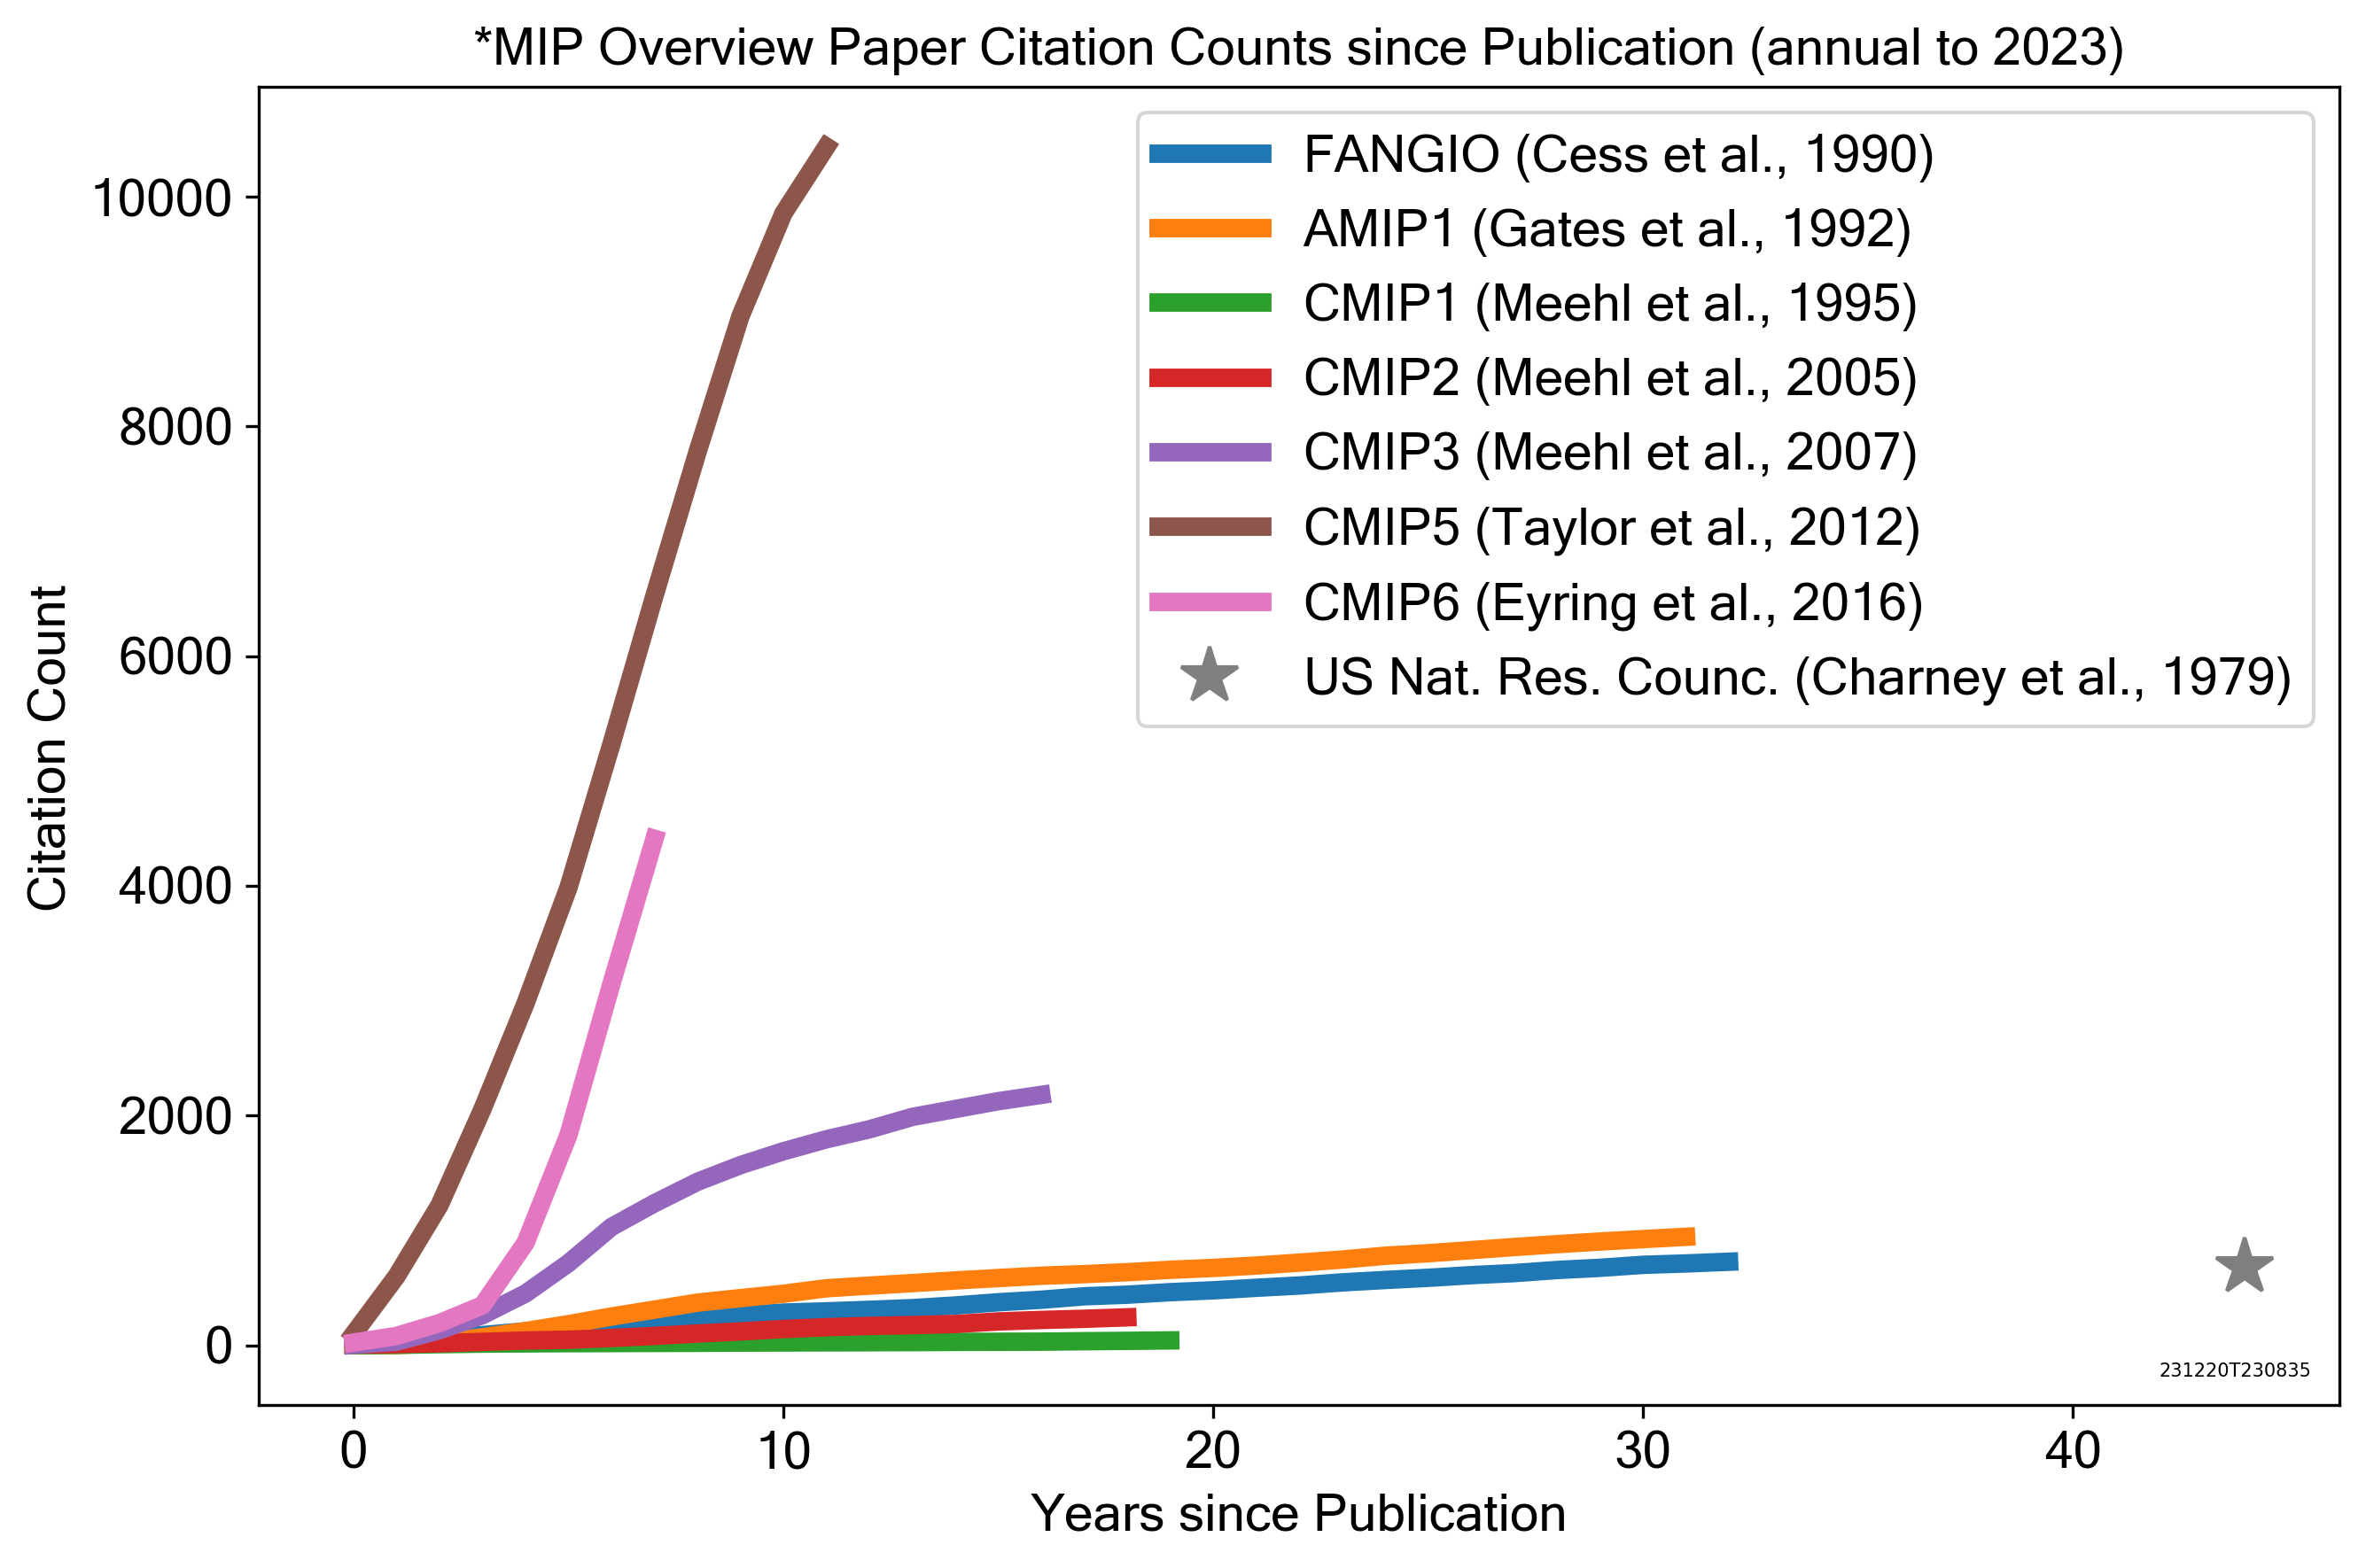

In [5]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
star0 = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})
plt.text(42, -270, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-1.png"]))

## second plot (a) - Contributing MIPs - line plot

actLabels: 25 ['AerChemMIP (Collins et al., 2017); 150', 'C4MIP (Jones et al., 2016); 145', 'CDRMIP (Keller et al., 2018); 83', 'CFMIP (Webb et al., 2017); 163', 'CORDEX (Gutowski et al., 2016); 234', 'DAMIP (Gillett et al., 2016); 231', 'DCPP (Boer et al., 2016); 244', 'DynVarMIP (Gerber & Manzini, 2016); 25', 'FAFMIP (Gregory et al., 2016); 107', 'GeoMIP6 (Kravitz et al., 2015); 114', 'GMMIP (Zhou et al., 2016); 69', 'HighResMIP (Haarsma et al., 2016); 555', 'ISMIP6 (Nowicki et al., 2016); 142', 'LS3MIP (va den Hurk et al., 2016); 124', 'LUMIP (Lawrence et al., 2016); 275', 'OMIP-Phys. (Griffies et al., 2016); 190', 'OMIP-BioGeoChem. (Orr et al., 2017); 122', 'PAMIP (Smith et al., 2019); 150', 'PMIP4 (Kageyama et al., 2018); 136', 'RFMIP (Pincus et al., 2016); 147', "ScenarioMIP (O'Neill et al., 2016); 1677", 'SIMIP (Notz et al., 2016); 65', 'VIACS AB (Ruane et al., 2016); 30', 'VolMIP (Zanchettin et al., 2016); 120', 'ZECMIP (Jones et al., 2019); 36']
mip: [nan, 5, 14, 14, 32, 21, 4

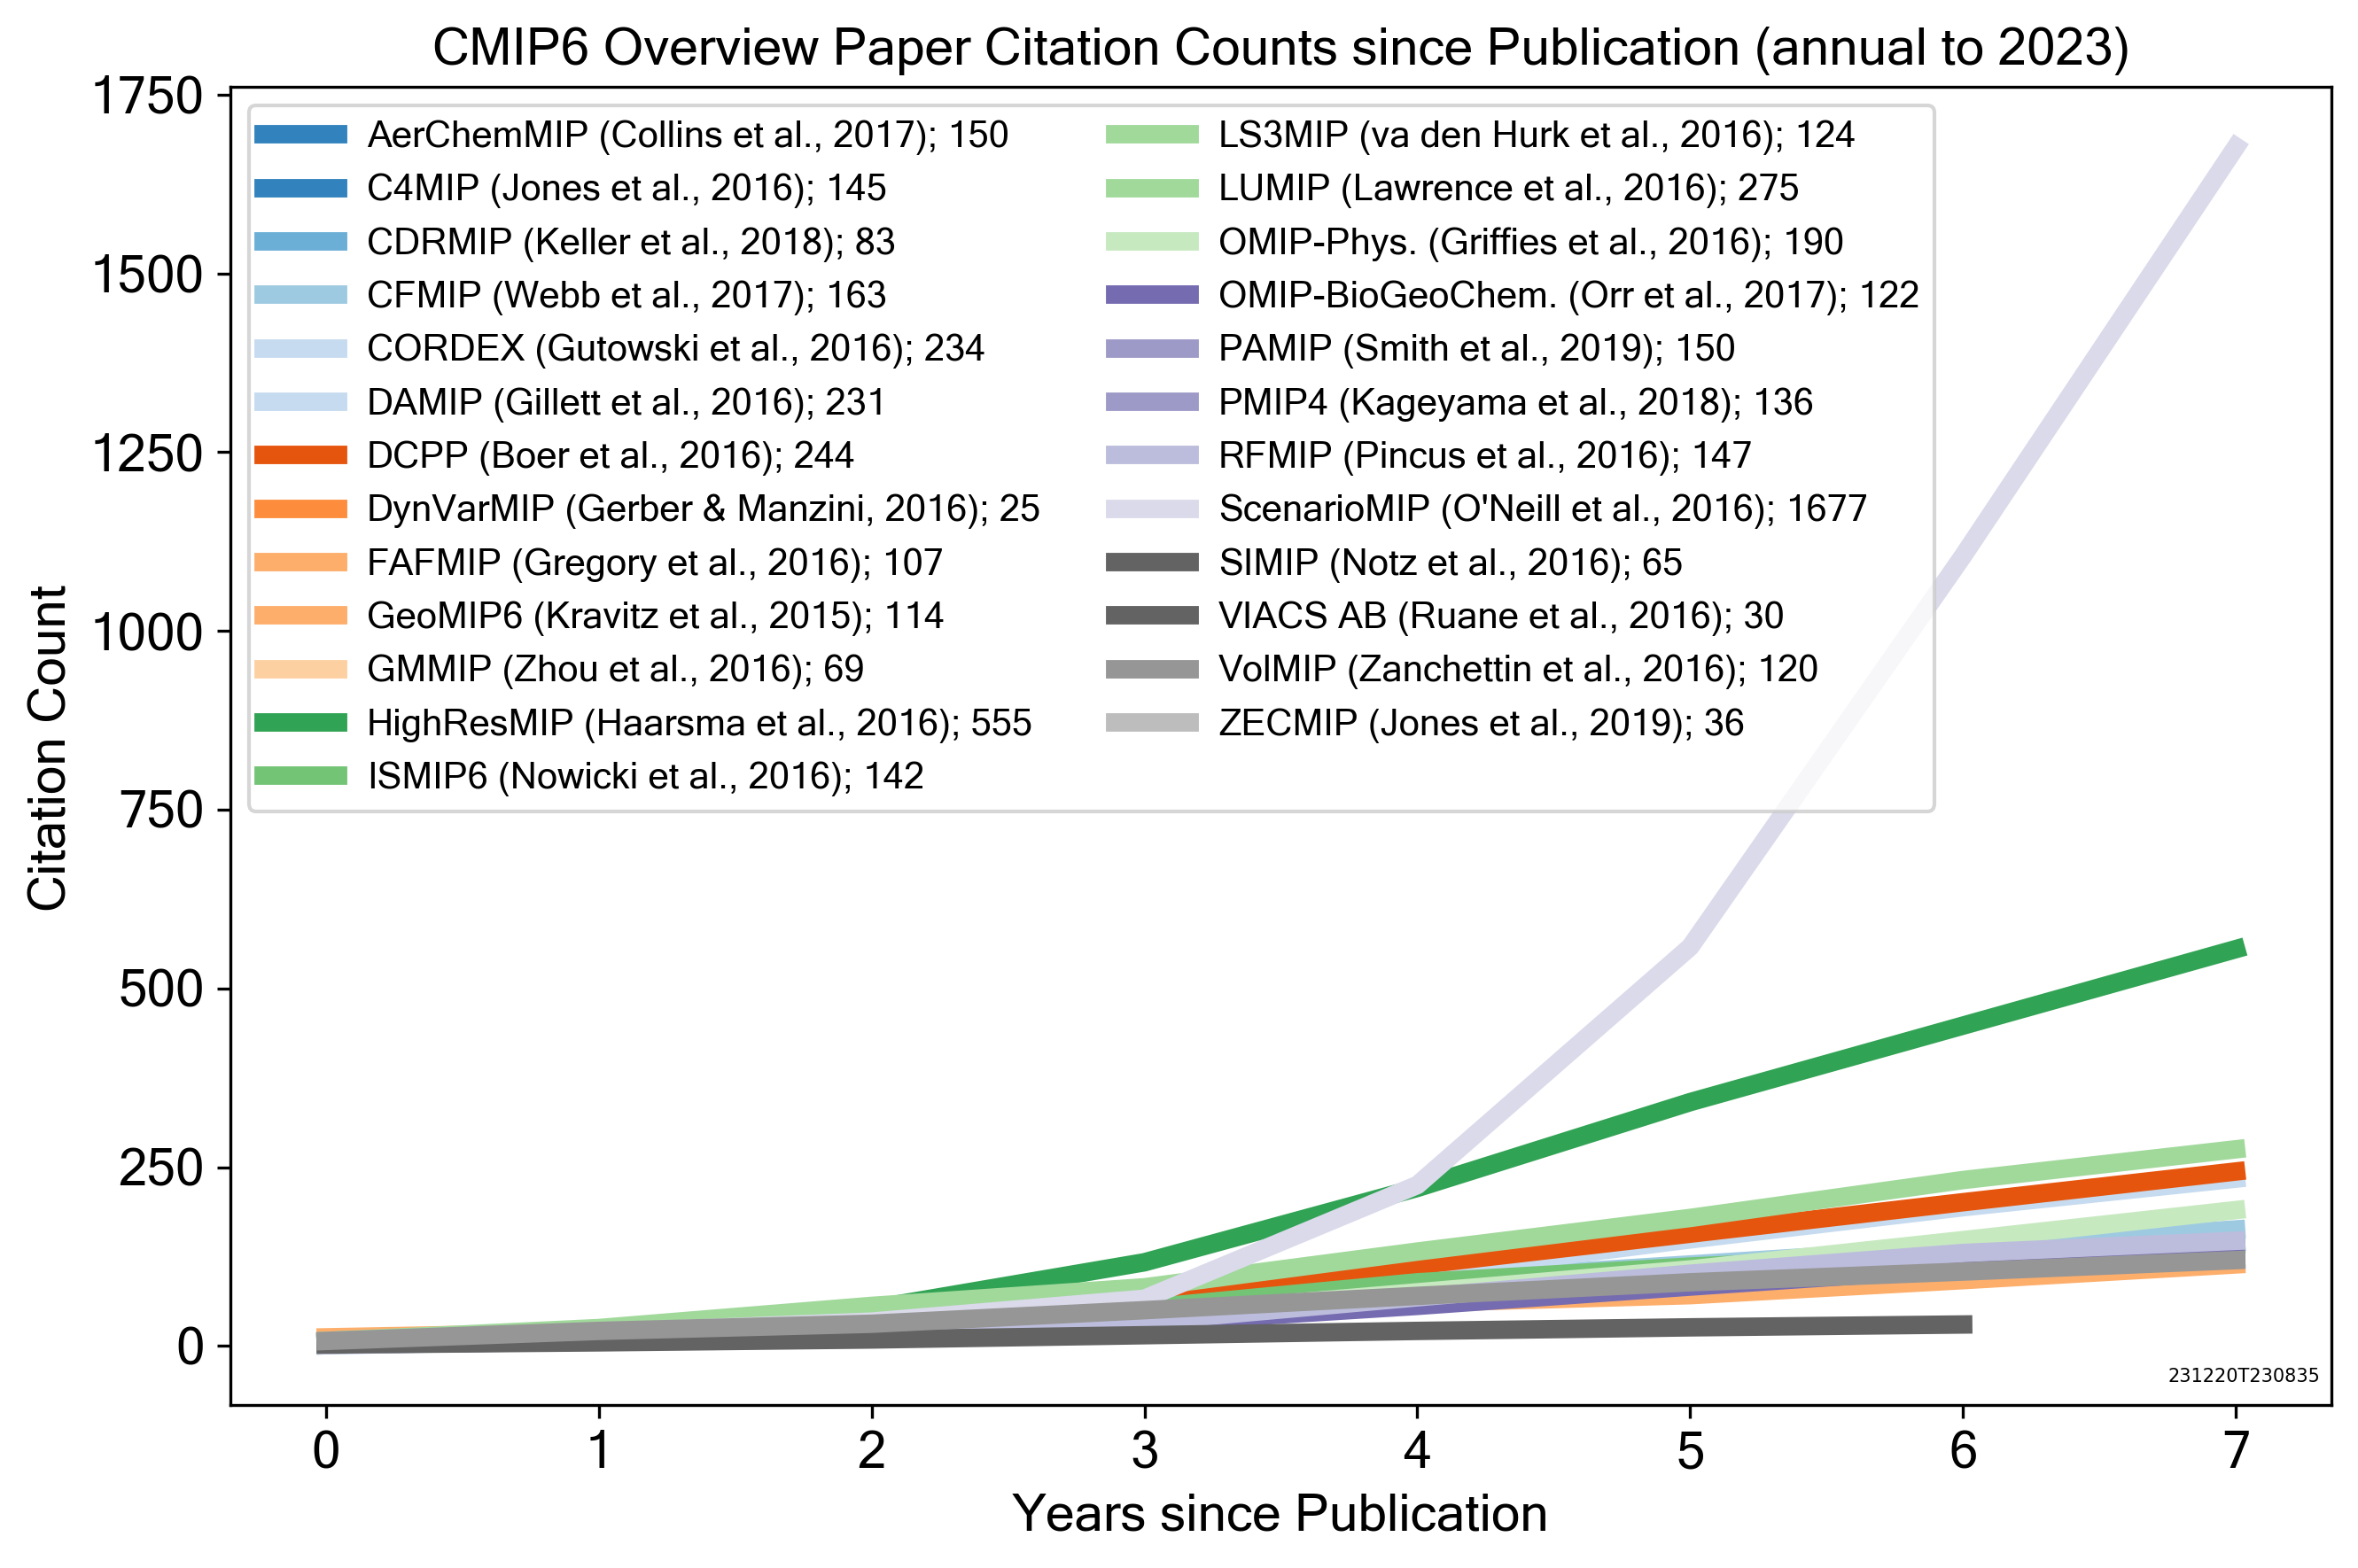

In [6]:
# Generate CMIP6 and per MIP
#cmip6Comp = np.cumsum([aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
#                       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
#                       simip, viacsab, volmip, zecmip], 0)
#cmip6Compa = copy.deepcopy(pad)
#cmip6Compa[:len(cmip6Comp)] = cmip6Comp
#cmip6Comp = cmip6Compa
#del(cmip6Compa)
#cmip6CompA = np.nansum([cmip6, cmip6Comp], 0)
#cmip6CompA = np.where(cmip6CompA == 0., np.nan, cmip6CompA)

# Year since publication
yrSincePublication2 = np.arange(0, len(aerchemmip))

# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"
NUM_COLORS = 26
colList = []
cm = plt.get_cmap('tab20c')  # also tab 20b, tab20
for i in range(NUM_COLORS):
    colList.append(cm(1.*i/NUM_COLORS))
# string format
f = "{:0.0f}"
    
# create labels
actLabels = []
#actLabels.append('; '.join(["CMIP6 (Eyring et al., 2016)", f.format(np.nansum(cmip6))]))
#actLabels.append('; '.join(["CMIP6 (Composite 2015-)", f.format(np.nansum(cmip6Comp))]))
actLabels.append('; '.join(["AerChemMIP (Collins et al., 2017)", f.format(np.nansum(aerchemmip))]))
actLabels.append('; '.join(["C4MIP (Jones et al., 2016)", f.format(np.nansum(c4mip))]))
actLabels.append('; '.join(["CDRMIP (Keller et al., 2018)", f.format(np.nansum(cdrmip))]))
actLabels.append('; '.join(["CFMIP (Webb et al., 2017)", f.format(np.nansum(cfmip))]))
actLabels.append('; '.join(["CORDEX (Gutowski et al., 2016)", f.format(np.nansum(cordex))]))
actLabels.append('; '.join(["DAMIP (Gillett et al., 2016)", f.format(np.nansum(damip))]))
actLabels.append('; '.join(["DCPP (Boer et al., 2016)", f.format(np.nansum(dcpp))]))
actLabels.append('; '.join(["DynVarMIP (Gerber & Manzini, 2016)", f.format(np.nansum(dynvarmip))]))
actLabels.append('; '.join(["FAFMIP (Gregory et al., 2016)", f.format(np.nansum(fafmip))]))
actLabels.append('; '.join(["GeoMIP6 (Kravitz et al., 2015)", f.format(np.nansum(geomip6))]))
actLabels.append('; '.join(["GMMIP (Zhou et al., 2016)", f.format(np.nansum(gmmip))]))
actLabels.append('; '.join(["HighResMIP (Haarsma et al., 2016)", f.format(np.nansum(highresmip))]))
actLabels.append('; '.join(["ISMIP6 (Nowicki et al., 2016)", f.format(np.nansum(ismip6))]))
actLabels.append('; '.join(["LS3MIP (va den Hurk et al., 2016)", f.format(np.nansum(ls3mip))]))
actLabels.append('; '.join(["LUMIP (Lawrence et al., 2016)", f.format(np.nansum(lumip))]))
actLabels.append('; '.join(["OMIP-Phys. (Griffies et al., 2016)", f.format(np.nansum(omip1))]))
actLabels.append('; '.join(["OMIP-BioGeoChem. (Orr et al., 2017)", f.format(np.nansum(omip2))]))
actLabels.append('; '.join(["PAMIP (Smith et al., 2019)", f.format(np.nansum(pamip))]))
actLabels.append('; '.join(["PMIP4 (Kageyama et al., 2018)", f.format(np.nansum(pmip4))]))
actLabels.append('; '.join(["RFMIP (Pincus et al., 2016)", f.format(np.nansum(rfmip))]))
actLabels.append('; '.join(["ScenarioMIP (O'Neill et al., 2016)", f.format(np.nansum(scenariomip))]))
actLabels.append('; '.join(["SIMIP (Notz et al., 2016)", f.format(np.nansum(simip))]))
actLabels.append('; '.join(["VIACS AB (Ruane et al., 2016)", f.format(np.nansum(viacsab))]))
actLabels.append('; '.join(["VolMIP (Zanchettin et al., 2016)", f.format(np.nansum(volmip))]))
actLabels.append('; '.join(["ZECMIP (Jones et al., 2019)", f.format(np.nansum(zecmip))]))
print("actLabels:", len(actLabels), actLabels)
                 
# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

#cmip6, cmip6Comp, 
mips = [aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
        highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
        simip, viacsab, volmip, zecmip]

# plot from year 1
for count, mip in enumerate(mips):
    print("mip:", mip)
    plt.plot(yrSincePublication2, np.cumsum(mip), linewidth=lineWidth, label=actLabels[count], color=colList[count])

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('CMIP6 Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": 10}, loc="upper left", ncol=2)
plt.text(6.75, -50, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2a.png"]))

## second plot (b) - Contributing MIPs - bar plot

valsum: [150.0, 145, 83.0, 163, 234, 231.0, 244, 25.0, 107.0, 114, 69.0, 555, 142, 124, 275, 190, 122, 150.0, 136.0, 147, 1677, 65.0, 30.0, 120, 36.0]
np.nansum(valsum): 5334.0
valsum %: [' 2.81%', ' 2.72%', ' 1.56%', ' 3.06%', ' 4.39%', ' 4.33%', ' 4.57%', ' 0.47%', ' 2.01%', ' 2.14%', ' 1.29%', '10.40%', ' 2.66%', ' 2.32%', ' 5.16%', ' 3.56%', ' 2.29%', ' 2.81%', ' 2.55%', ' 2.76%', '31.44%', ' 1.22%', ' 0.56%', ' 2.25%', ' 0.67%']
np.nansum(valsum %): 100.00000000000001
len(valsum): 25 ; len(labs): 25


/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_47165/1767139706.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.axes.axes.set_yticklabels(ax1.get_yticklabels(), fontsize=fontSize, fontname=fontname)
/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_47165/1767139706.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.axes.axes.set_yticklabels(ax2.get_yticklabels(), fontsize=fontSize, fontname=fontname)
/var/folders/7d/rkhc67xs5w70chjmlrr6pv440017ch/T/ipykernel_47165/1767139706.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


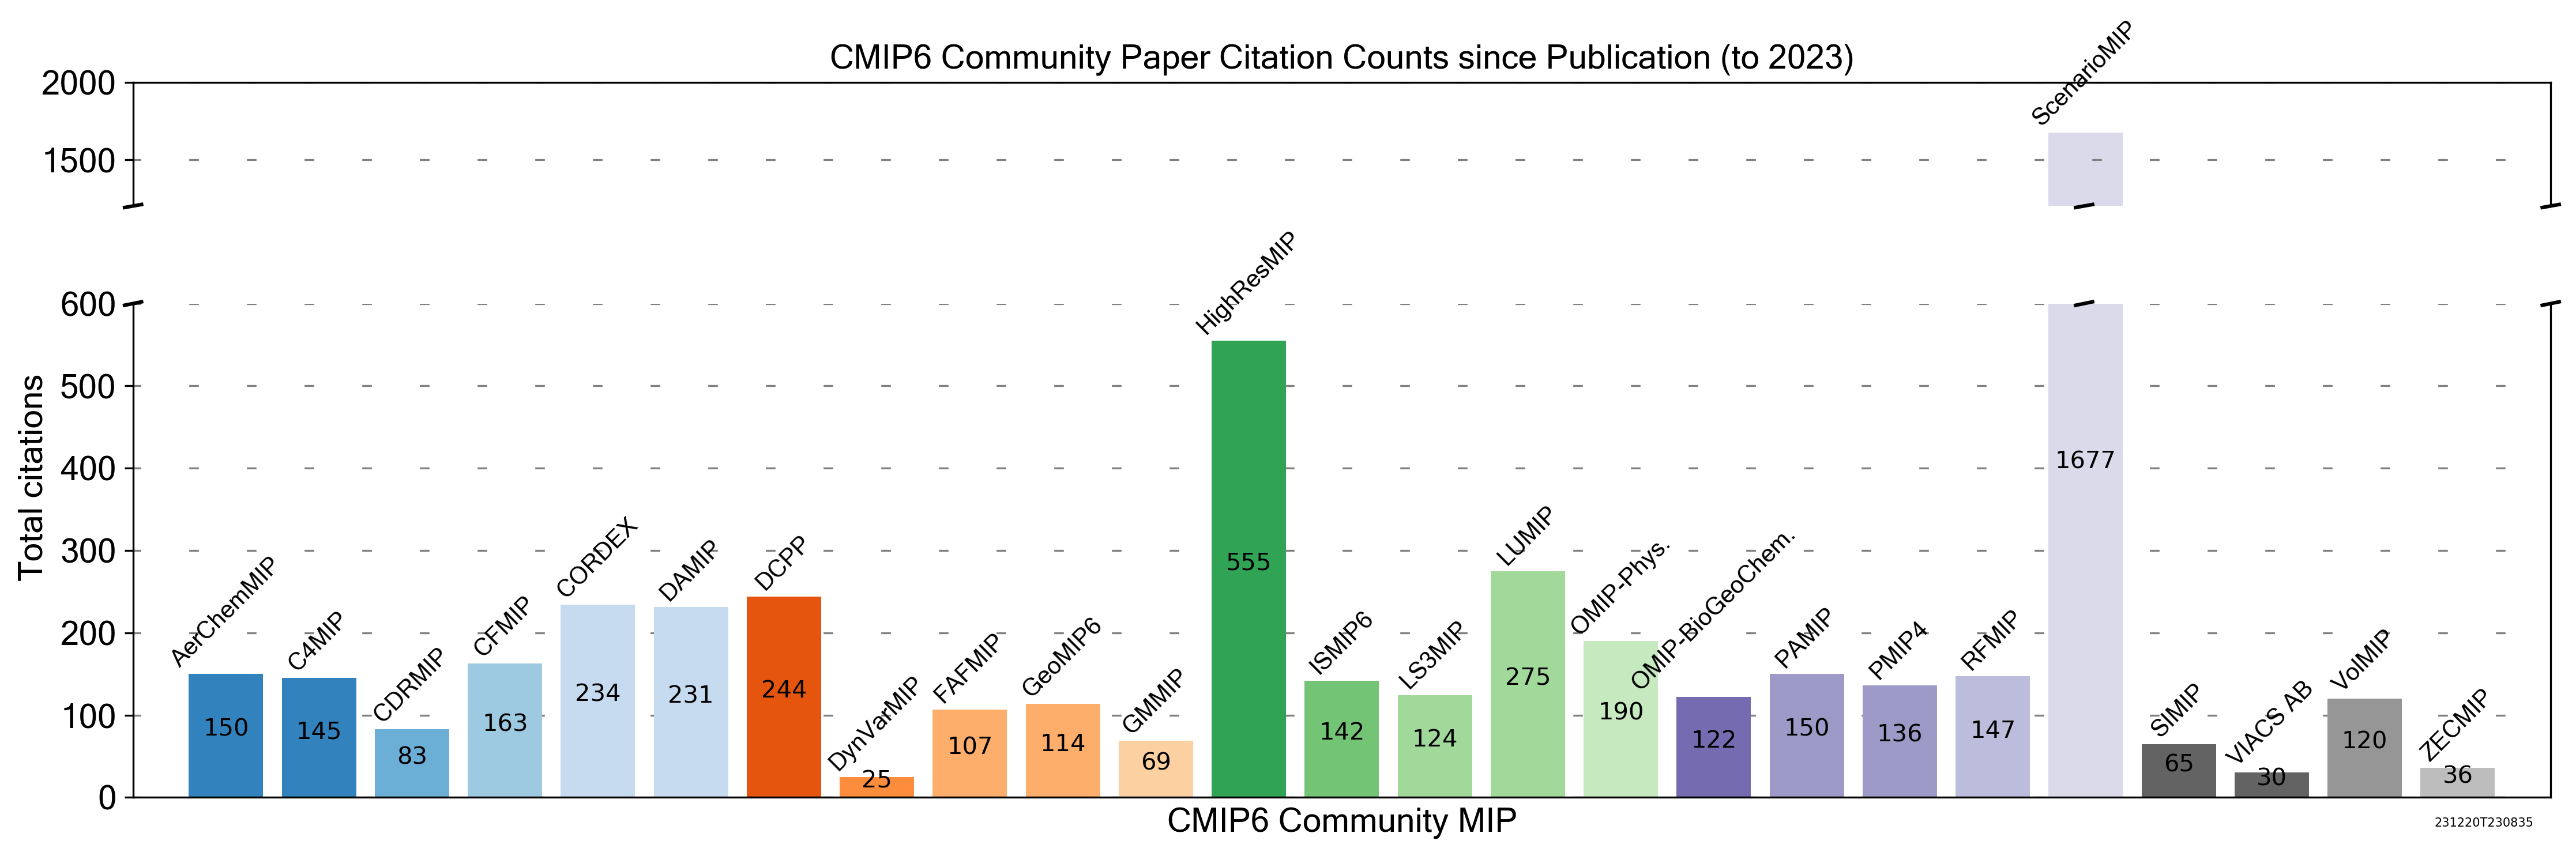

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=300, ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 4]})

# sort axis boxes
ax1.spines[['bottom']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax1.set_ylim(1200, 2000)
ax2.set_ylim(0, 600)
ax1.set_xlim(-1, 25)
ax2.set_xlim(-1, 25)
fig.tight_layout()

# fixed values
linesty = (1, (5, 25))
rot = 45
fontname = "Microsoft Sans Serif"
fontSize = 14
fontSizeLab = 10

# create colour bins
NUM_COLORS = 26
colList = []
cm = plt.get_cmap('tab20c')  # also tab 20b, tab20
for i in range(NUM_COLORS):
    colList.append(cm(1.*i/NUM_COLORS))

val = [aerchemmip, c4mip, cdrmip, cfmip, cordex, damip, dcpp, dynvarmip, fafmip, geomip6, gmmip,
       highresmip, ismip6, ls3mip, lumip, omip1, omip2, pamip, pmip4, rfmip, scenariomip,
       simip, viacsab, volmip, zecmip]
labs = ["AerChemMIP", "C4MIP", "CDRMIP", "CFMIP", "CORDEX", "DAMIP", "DCPP",
        "DynVarMIP", "FAFMIP", "GeoMIP6", "GMMIP", "HighResMIP", "ISMIP6", "LS3MIP",
        "LUMIP", "OMIP-Phys.", "OMIP-BioGeoChem.", "PAMIP", "PMIP4", "RFMIP",
        "ScenarioMIP", "SIMIP", "VIACS AB", "VolMIP", "ZECMIP"]
valsum = []
for c,v in enumerate(val):
    tmp = np.nansum(v)
    valsum.append(tmp)

print("valsum:", valsum)
f = "{:5.2f}%"
print("np.nansum(valsum):", np.nansum(valsum))
perc = valsum/np.nansum(valsum) * 100
#print("valsum/np.nansum(valsum):", perc)
print("valsum %:", list(map(f.format,perc)))
print("np.nansum(valsum %):", np.nansum(perc))
print("len(valsum):", len(valsum), "; len(labs):", len(labs))

# Start plotting
b1 = ax1.bar(labs, valsum, color=colList)
b2 = ax2.bar(labs, valsum, color=colList)
ax1.grid(zorder=0)
ax1.grid(color='gray', linestyle=linesty)
ax1.bar_label(b1, labs, label_type='edge', color='k', rotation=rot, fontsize=fontSizeLab, padding=1, zorder=10, fontname=fontname)
ax1.axes.axes.set_yticklabels(ax1.get_yticklabels(), fontsize=fontSize, fontname=fontname)
ax2.grid(zorder=0)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle=linesty)
ax2.bar_label(b2, labs, label_type='edge', color='k', rotation=rot, fontsize=fontSizeLab, padding=1, zorder=10, fontname=fontname)
ax2.set_ylabel("Total citations", fontsize=fontSize, fontname=fontname)
ax2.yaxis.set_label_coords(-.035, .65)
ax2.axes.axes.set_yticklabels(ax2.get_yticklabels(), fontsize=fontSize, fontname=fontname)
ax2.set_xlabel("CMIP6 Community MIP", fontsize=fontSize, fontname=fontname)
ax2.set_xticks([])
ax1.set_title("CMIP6 Community Paper Citation Counts since Publication (to 2023)",
             fontsize=fontSize, fontname=fontname)
plt.text(23.75, -35, ' '.join([timeFormat]), fontsize=5)

# function to add value labels
f = "{:0.0f}"
def addlabels(x,y):
    for i in range(len(x)):
        y1 = f.format(y[i])
        if i == 20:
            plt.text(i, 400, y1, ha = "center")
        else:
            plt.text(i, y[i]//2, y1, ha = "center")

addlabels(labs, valsum)

# arguments to pass to plot, just so we don't keep repeating them
# following https://gist.github.com/pfandzelter/0ae861f0dee1fb4fd1d11344e3f85c9e
d = .0035  # how big to make the diagonal lines in axes coordinates
scale = 350/100  # upper scale more compressed
scenX = .807  # ScenarioMIP x-intercept
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-d*scale, +d*scale), **kwargs)  # top-left diagonal
ax1.plot((scenX - d, scenX + d), (-d*scale, +d*scale), **kwargs)  # ScenarioMIP diagonal
ax1.plot((1 - d, 1 + d), (-d*scale, +d*scale), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((scenX - d, scenX + d), (1 -d, 1 +d), **kwargs)  # ScenarioMIP diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-2b-bar.png"]))

## third plot - MIPs and composite CMIP6

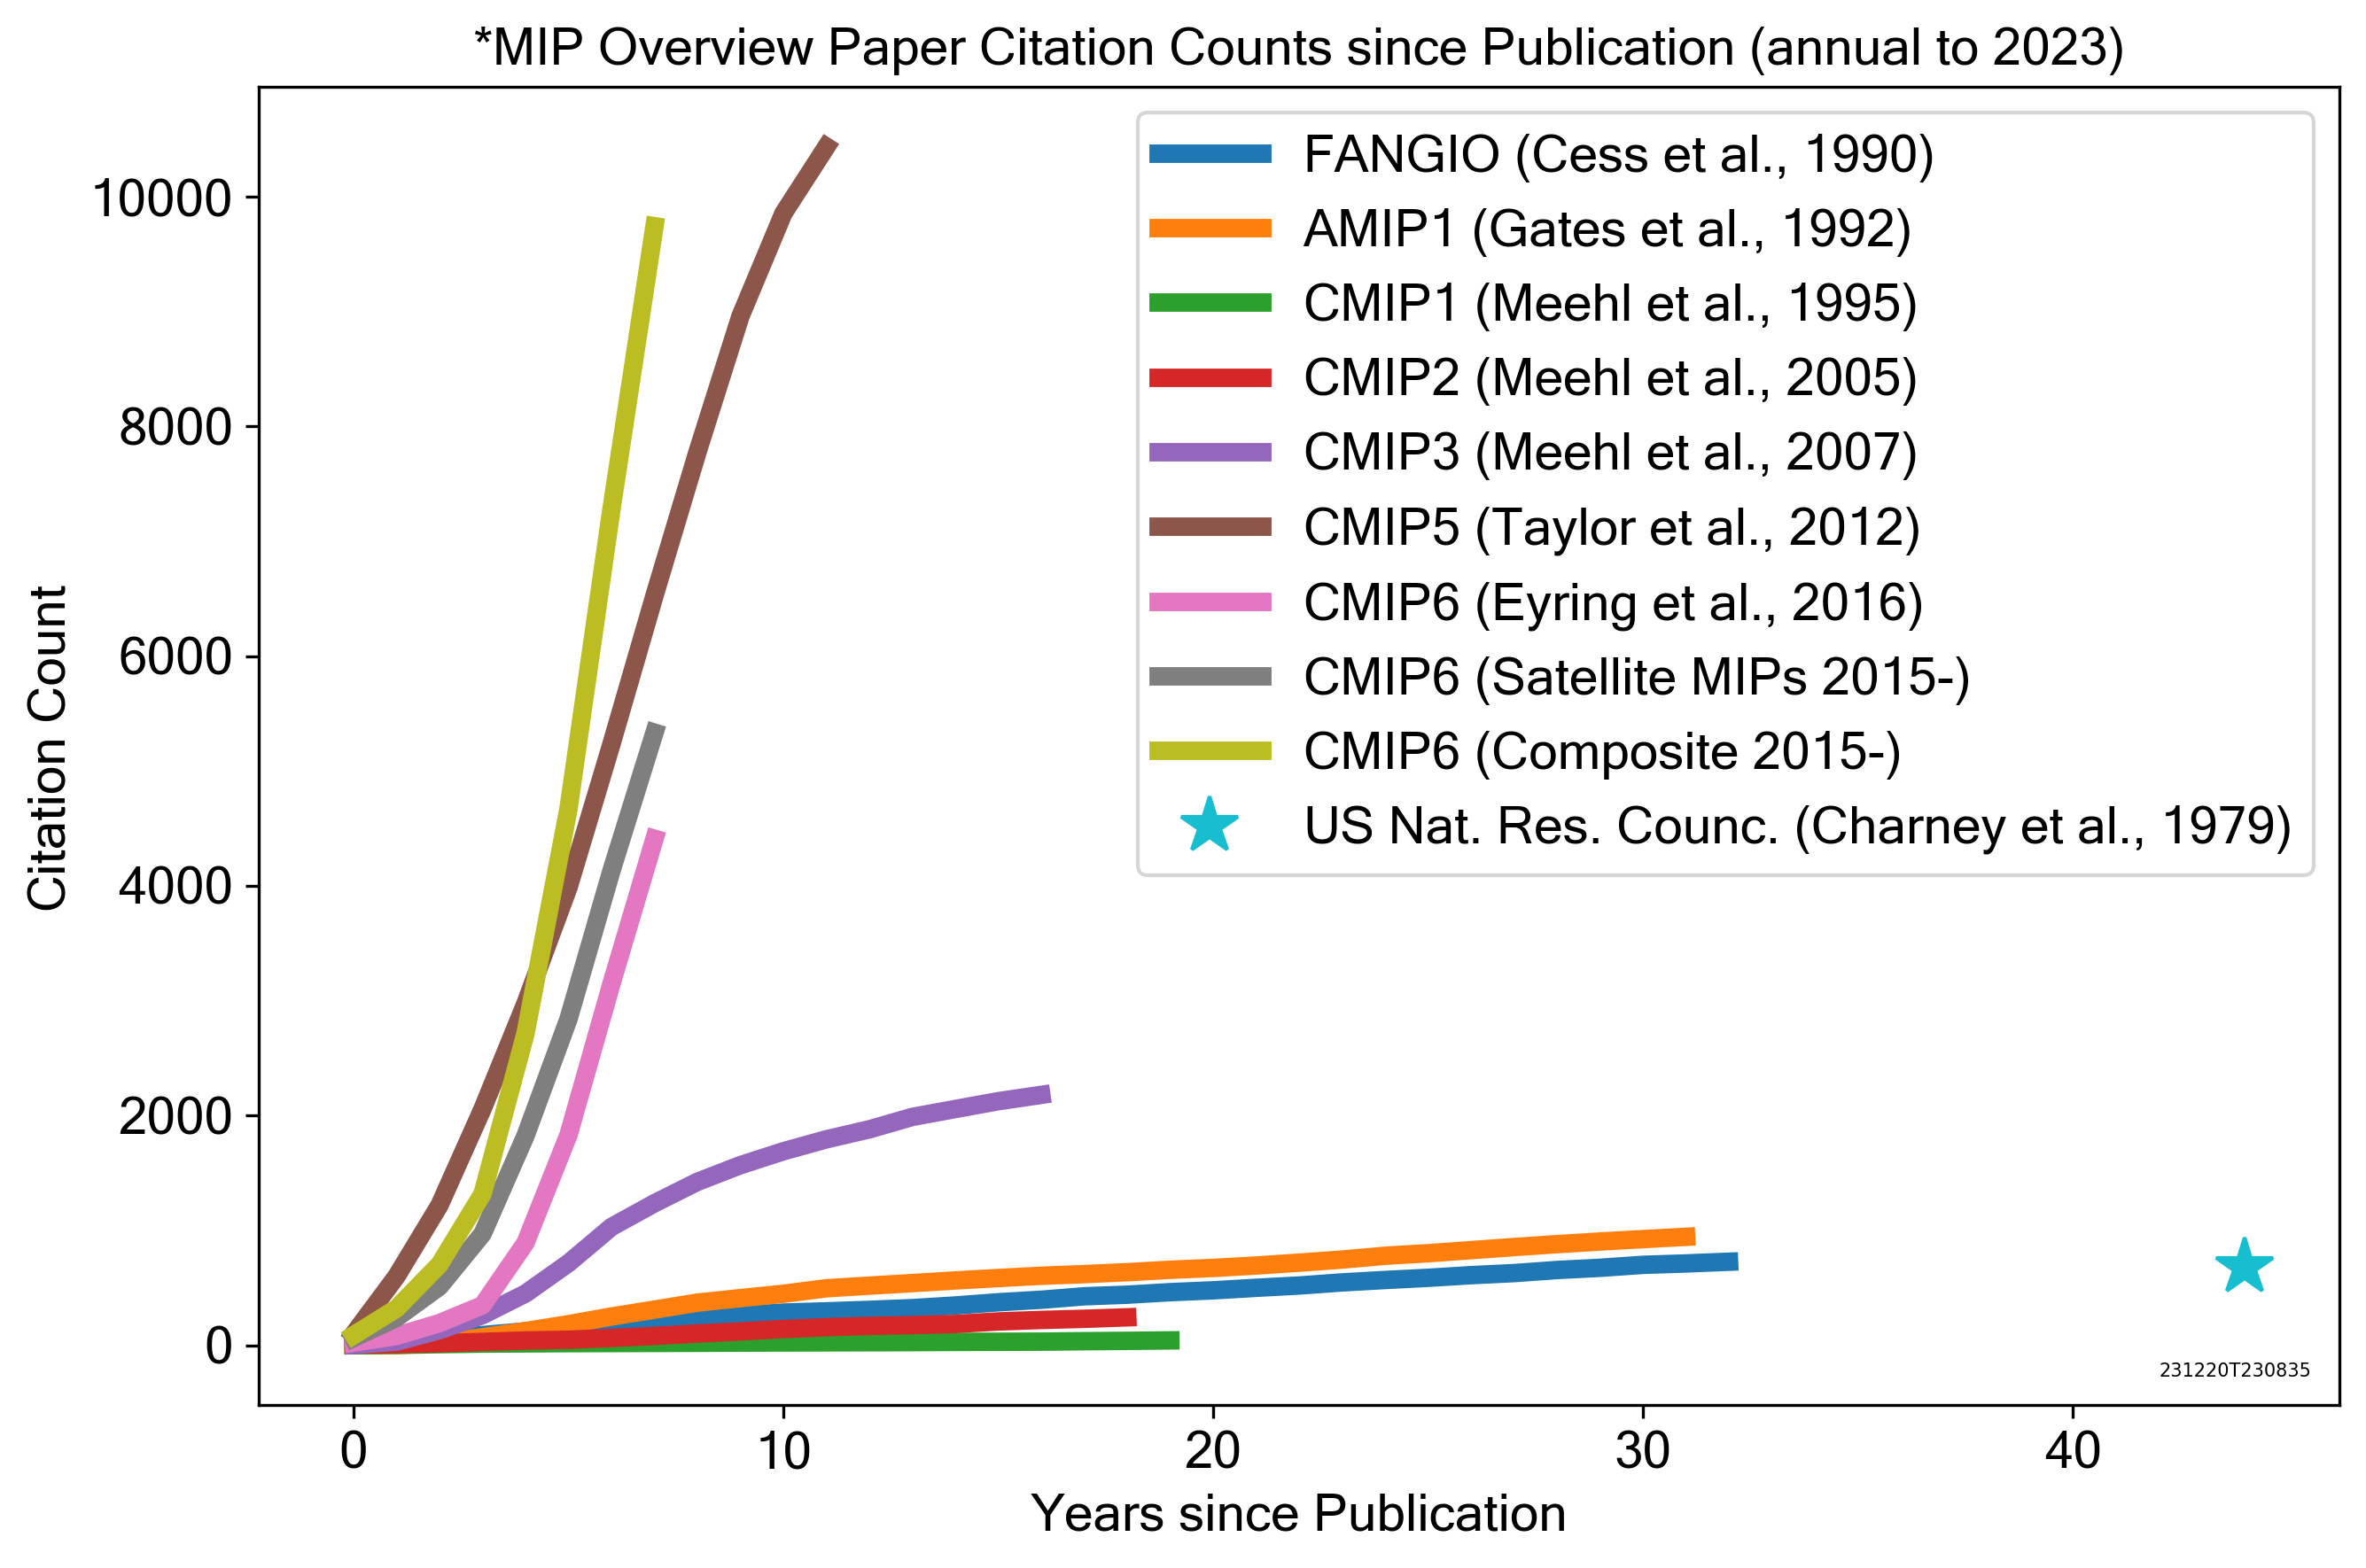

In [8]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0 = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth, label="FANGIO (Cess et al., 1990)")
line1 = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth, label="AMIP1 (Gates et al., 1992)")
line2 = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth, label="CMIP1 (Meehl et al., 1995)")
line3 = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth, label="CMIP2 (Meehl et al., 2005)")
line4 = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth, label="CMIP3 (Meehl et al., 2007)")
line5 = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth, label="CMIP5 (Taylor et al., 2012)")
line6 = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth, label="CMIP6 (Eyring et al., 2016)")
line7 = plt.plot(yrSincePublication, np.cumsum(cmip6Comp), linewidth=lineWidth, label="CMIP6 (Satellite MIPs 2015-)")
line8 = plt.plot(yrSincePublication, np.cumsum(cmip6CompA), linewidth=lineWidth, label="CMIP6 (Composite 2015-)")
star0 = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None", label="US Nat. Res. Counc. (Charney et al., 1979)")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend(prop={"family": fontName, "size": fontsize})
plt.text(42, -270, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-3.png"]))

# fourth plot - MIPs + CCSM4, CESM1, CESM2, E3SM-1-0

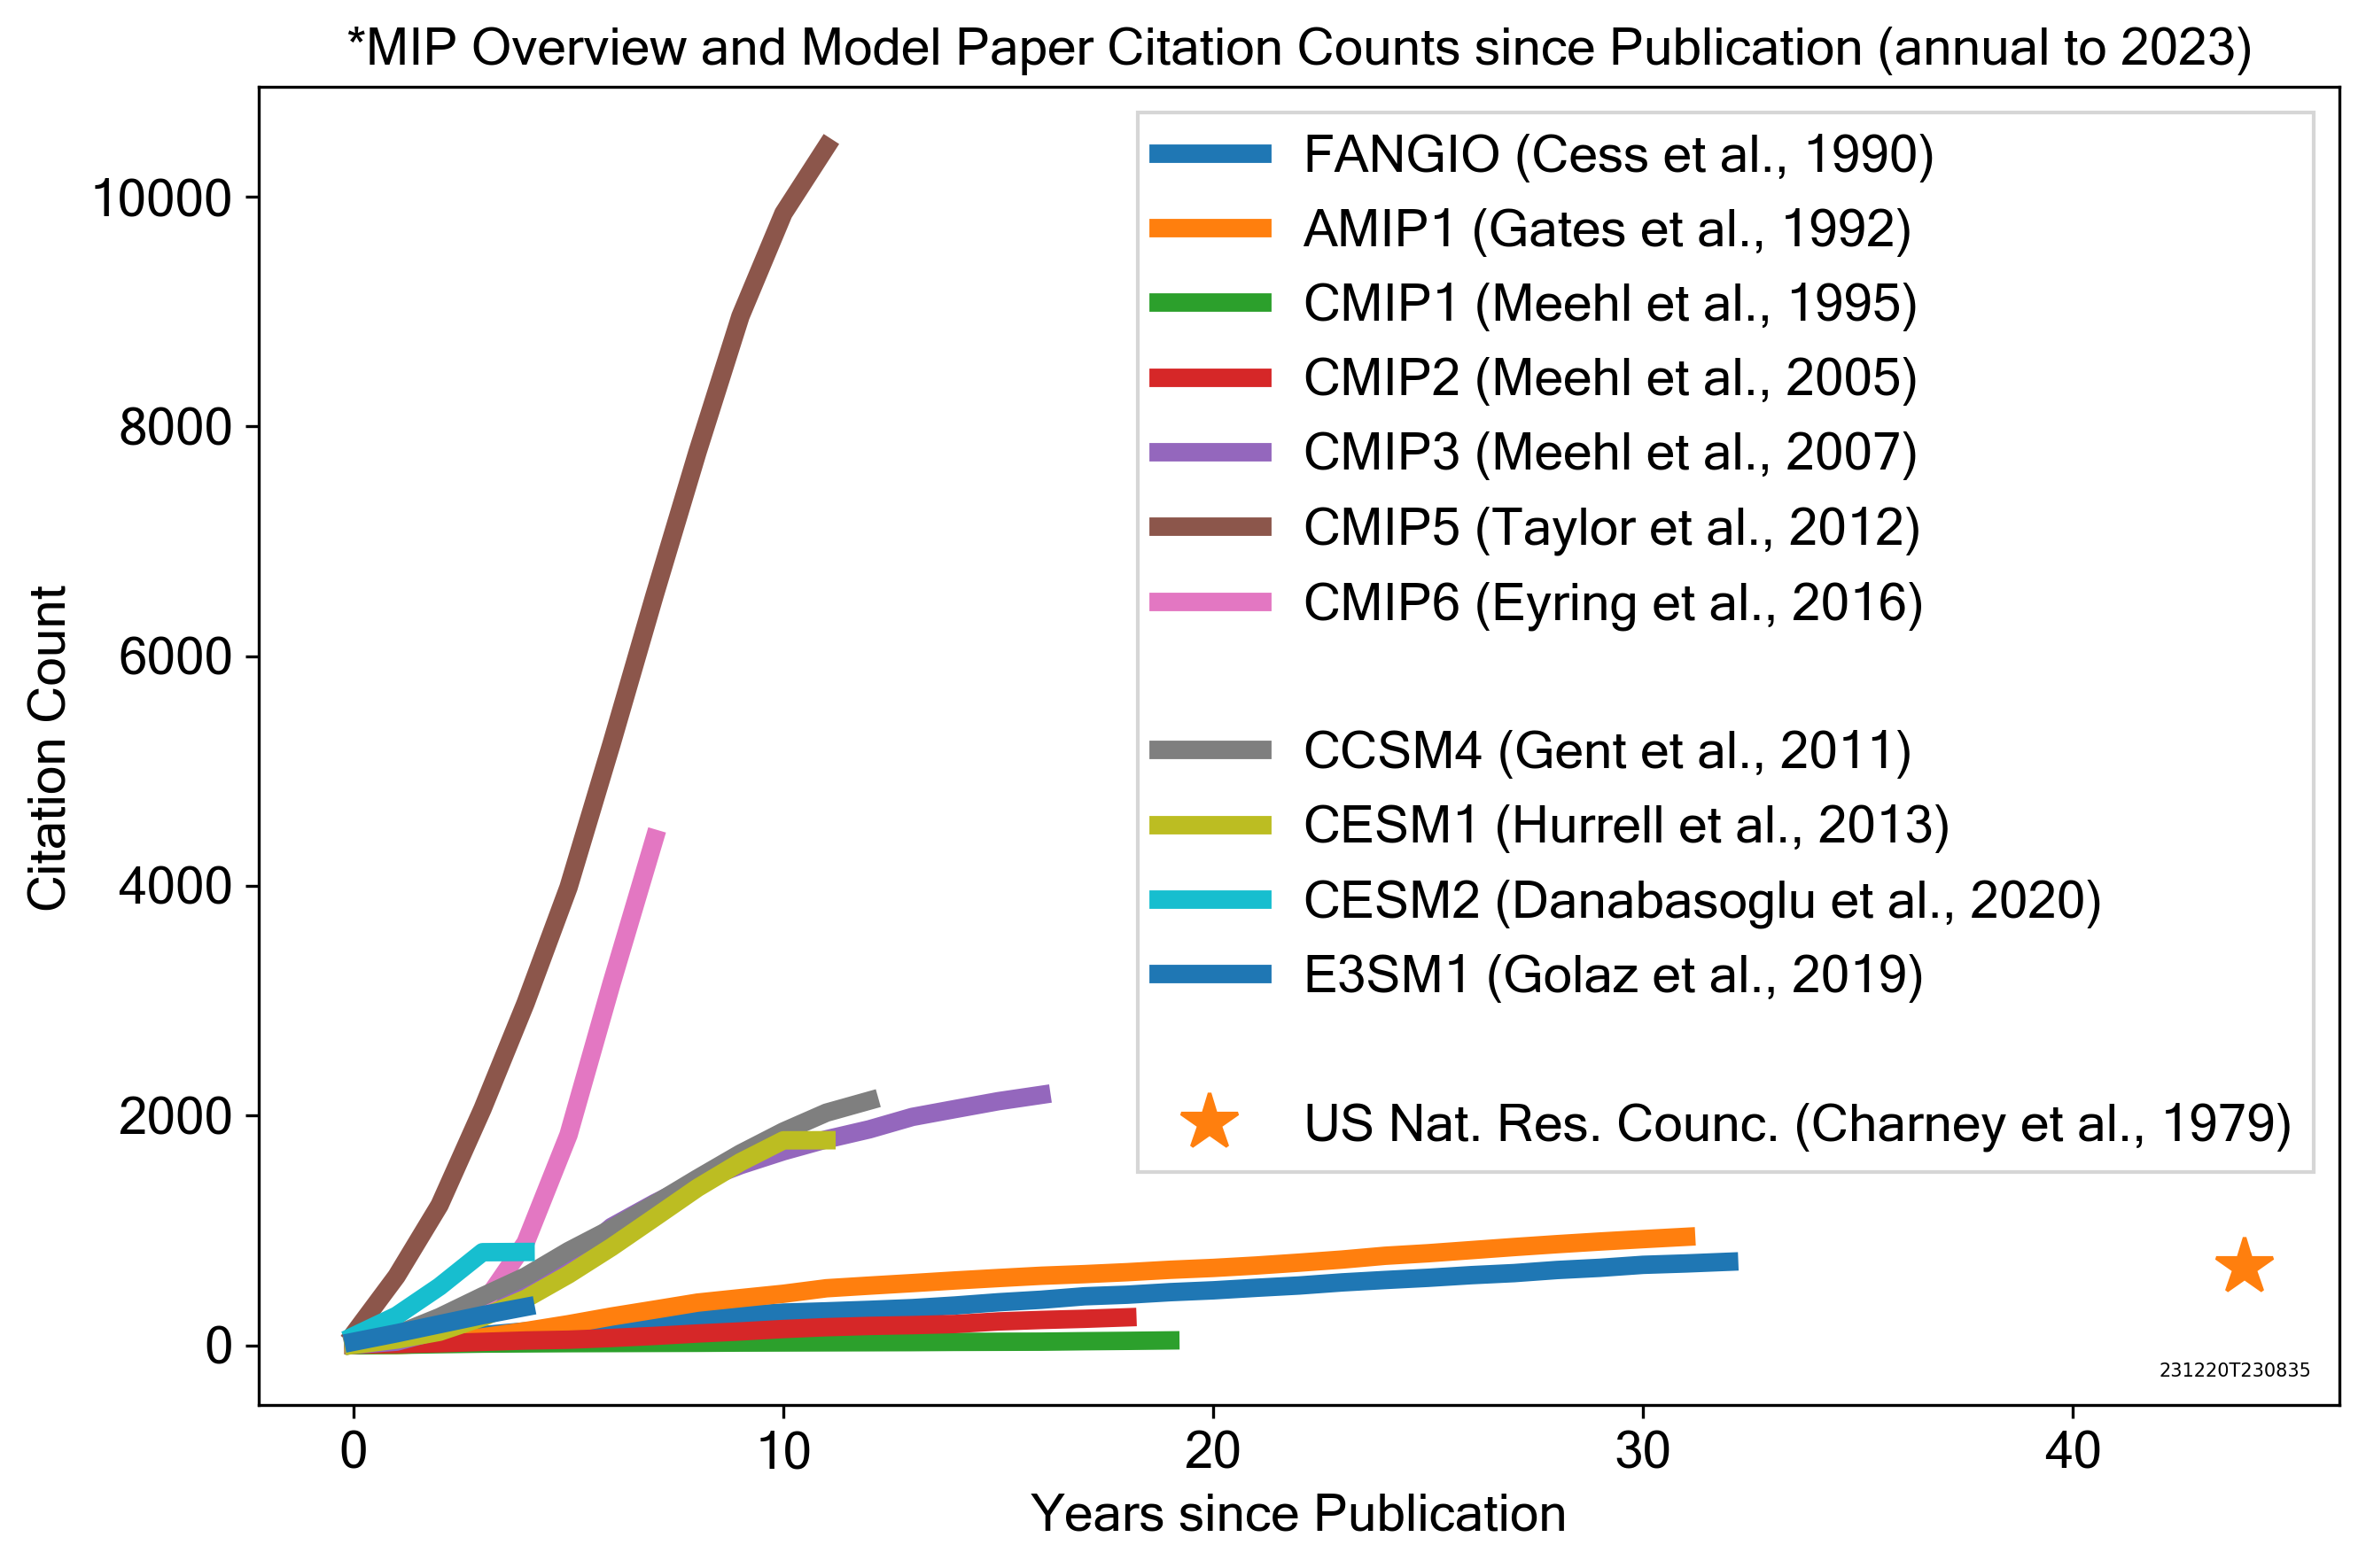

In [9]:
# set inputs
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars
fontsize = 14
lineWidth = 5
fontName = "Microsoft Sans Serif"

# initialize canvas
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# plot from year 1
line0, = plt.plot(yrSincePublication, np.cumsum(fangio), linewidth=lineWidth)
line1, = plt.plot(yrSincePublication, np.cumsum(amip1), linewidth=lineWidth)
line2, = plt.plot(yrSincePublication, np.cumsum(cmip1), linewidth=lineWidth)
line3, = plt.plot(yrSincePublication, np.cumsum(cmip2), linewidth=lineWidth)
line4, = plt.plot(yrSincePublication, np.cumsum(cmip3), linewidth=lineWidth)
line5, = plt.plot(yrSincePublication, np.cumsum(cmip5), linewidth=lineWidth)
line6, = plt.plot(yrSincePublication, np.cumsum(cmip6), linewidth=lineWidth)
line7, = plt.plot(yrSincePublication, pad, color="w")
line8, = plt.plot(yrSincePublication, np.cumsum(ccsm4), linewidth=lineWidth)
line9, = plt.plot(yrSincePublication, np.cumsum(cesm1), linewidth=lineWidth)
line10, = plt.plot(yrSincePublication, np.cumsum(cesm2), linewidth=lineWidth)
line11, = plt.plot(yrSincePublication, np.cumsum(e3sm1_0), linewidth=lineWidth)
line12, = plt.plot(yrSincePublication, pad, color="w")
star0, = plt.plot(2023-1979, charneyGS, marker="*", markersize=16, linestyle="None")

# pretty things up - add text for labels, title and custom x-axis tick labels, etc.
ax.set_title('*MIP Overview and Model Paper Citation Counts since Publication (annual to 2023)',
             fontname=fontName, fontsize=fontsize)
ax.set_ylabel('Citation Count', fontname=fontName, fontsize=fontsize)
plt.yticks(fontname=fontName, fontsize=fontsize)
ax.set_xlabel("Years since Publication", fontname=fontName, fontsize=fontsize)
plt.xticks(fontname=fontName, fontsize=fontsize)
ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8, line9, line10, line11, line12, star0),
          ("FANGIO (Cess et al., 1990)", "AMIP1 (Gates et al., 1992)", "CMIP1 (Meehl et al., 1995)",
           "CMIP2 (Meehl et al., 2005)", "CMIP3 (Meehl et al., 2007)", "CMIP5 (Taylor et al., 2012)",
           "CMIP6 (Eyring et al., 2016)", "", "CCSM4 (Gent et al., 2011)",
           "CESM1 (Hurrell et al., 2013)", "CESM2 (Danabasoglu et al., 2020)",
           "E3SM1 (Golaz et al., 2019)", "", "US Nat. Res. Counc. (Charney et al., 1979)"),
          loc='upper right', fancybox=False, ncol=1,
          prop={"family": fontName, "size": fontsize})
plt.text(42, -270, ' '.join([timeFormat]), fontsize=5)

# fill canvas
fig.tight_layout()

# display, save and close
plt.show()
fig.savefig("_".join([timeFormat, "CMIPOverviewPaperCitations-Counts-4.png"]))